# Data Crawling

In [2]:
import requests
import pandas as pd

def get_binance_ohlcv(symbol="BTCUSDT", interval="1h", start="2021-01-01", end="2026-02-19"):
    url = "https://fapi.binance.com/fapi/v1/klines"
    start_ms = int(pd.Timestamp(start).timestamp() * 1000)
    end_ms   = int(pd.Timestamp(end).timestamp() * 1000)
    
    all_data = []
    while start_ms < end_ms:
        params = {"symbol": symbol, "interval": interval,
                  "startTime": start_ms, "endTime": end_ms, "limit": 1000}
        resp = requests.get(url, params=params).json()
        if not resp:
            break
        all_data.extend(resp)
        start_ms = resp[-1][0] + 1  # move to next timestamp for next candle

    df = pd.DataFrame(all_data, columns=[
        "open_time","open","high","low","close","volume",
        "close_time","quote_volume","trades",
        "taker_buy_base","taker_buy_quote","ignore"
    ])
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df[["open","high","low","close","volume"]] = df[["open","high","low","close","volume"]].astype(float)
    return df

df = get_binance_ohlcv()
# df.to_csv("binance_btcusdt_1h.csv", index=False)

# Data Cleaning

In [3]:
# df = df.isna().sum()
ohlc_violations = (
    (df["high"] < df["low"]) |       
    (df["high"] < df["open"]) |         
    (df["high"] < df["close"]) |          
    (df["low"] > df["open"]) |            
    (df["low"] > df["close"])             
)
ohlc_violations_count = ohlc_violations.sum()
print(f"Number of OHLC violations: {ohlc_violations_count}")

df["open_time"] = pd.to_datetime(df["open_time"], unit="hrs")
df = df.rename(columns={"open_time": "timestamp"})
df.drop(columns=["close_time", "quote_volume", "trades", "taker_buy_base", "taker_buy_quote", "ignore"], inplace=True)

Number of OHLC violations: 0


# Alpha Definition

### Alpha A (Geometric mean of the bar minus VWAP)

In [4]:
import numpy as np

# how far it is the geometric mean is from VWAP

typical_price = (df["high"] + df["low"] + df["close"]) / 3  # encode the information of the bar biased towards closing price
df["VWAP"] = (typical_price * df["volume"]).rolling(24).sum() / df["volume"].rolling(24).sum()
df["alpha_A"] = np.sqrt(df["high"] * df["low"]) - df["VWAP"] # geometric mean of the bar minus VWAP

### Alpha B (where the bar close divided by amplified open-to-close ratio)

In [5]:
# alpha_B = -(C - L)/(H - L) × (O/C)^5        [0,-inf)
# bar close high -> (C - L)/(H - L) close to 1, bar close low -> (C - L)/(H - L) close to 0, bar close middle -> (C - L)/(H - L) close to 0.5
# final value more negative -> more bullish, final value closer to 0 -> more bearish

df["alpha_B"] = -1 * ((df["low"] - df["close"]) * (df["open"] ** 5))/((df["low"]-df["high"])*(df["close"]**5))

### Alpha C (candle body to range ratio)

In [6]:
# close to 1 -> very bullish
# close to 0 -> doji
# close to -1 -> very bearish

df["alpha_C"] = (df["close"] - df["open"]) / (df["high"] - df["low"]) + 0.001

In [7]:
df.tail()

,timestamp,open,high,low,close,volume,VWAP,alpha_A,alpha_B,alpha_C
44996,2026-02-18 20:00:00,66138.3,66528.8,66098.9,66230.2,7627.587,67246.441195,-932.939566,-0.303307,0.214771
44997,2026-02-18 21:00:00,66230.3,66466.8,65993.1,66300.6,5568.422,67206.724016,-977.197526,-0.645711,0.149406
44998,2026-02-18 22:00:00,66300.5,66451.5,66192.7,66379.0,1860.076,67193.476189,-871.502424,-0.715614,0.304323
44999,2026-02-18 23:00:00,66379.0,66472.6,66240.0,66422.8,2506.522,67177.334875,-821.136793,-0.783311,0.189306
45000,2026-02-19 00:00:00,66422.8,66573.6,66301.8,66410.7,2414.967,67163.378280,-725.817274,-0.401027,-0.043518


# Backtesting

### Data Split

In [89]:
# Drop the data that are too old
df_clean = df[df["timestamp"] >= "2023-06-01"].reset_index(drop=True)

split_index = int(len(df_clean) * 0.65)
backtest_df = df_clean.iloc[:split_index].copy()
test_df = df_clean.iloc[split_index:].copy()

In [ ]:
def run_backtest(df, lookback=24,alpha_1_threshold=1, alpha_2_threshold=1):
    alpha_A_z = (df["alpha_A"] - df["alpha_A"].rolling(lookback).mean())/df["alpha_A"].rolling(lookback).std()
    alpha_C_z = (df["alpha_C"] - df["alpha_C"].rolling(lookback).mean())/df["alpha_C"].rolling(lookback).std()
    
    signal = pd.Series(0, index=df.index)
    signal[(alpha_A_z >= alpha_1_threshold) & (alpha_C_z <= -alpha_2_threshold)] = -1  # Short
    signal[(alpha_A_z <= -alpha_1_threshold) & (alpha_C_z >= alpha_2_threshold)] = 1   # Long

    returns = df["close"].pct_change().shift(-1) * signal
    num_trades = (signal != 0).sum()
    return returns, num_trades


lookback_range = [2, 4, 6, 12, 24, 48, 72, 96, 120, 144]
alpha_1_threshold_range = np.arange(0.3, 4, 0.1)  
alpha_2_threshold_range = np.arange(0.3, 4, 0.1)  

results = []
for lookback in lookback_range:
    for a1 in alpha_1_threshold_range:
        for a2 in alpha_2_threshold_range:
            r, n = run_backtest(backtest_df, lookback, a1, a2)
            if r.std() == 0 or n == 0:
                sharpe = np.nan
            else:
                sharpe = r.mean() / r.std() * np.sqrt(8760)
            results.append((lookback, round(a1, 1), round(a2, 1), n, sharpe))

results_df = pd.DataFrame(results, columns=["lookback", "alpha_1_threshold", "alpha_2_threshold", "num_trades", "sharpe_ratio"])

MIN_TRADES = 50
filtered = results_df[
    (results_df["num_trades"] >= MIN_TRADES) &
    (results_df["sharpe_ratio"].notna())
]

filtered = filtered.sort_values("sharpe_ratio", ascending=False)

best = filtered.iloc[0]
neighbours = results_df[
    (results_df["lookback"] == best["lookback"]) &
    (results_df["alpha_1_threshold"].between(best["alpha_1_threshold"] - 0.2, best["alpha_1_threshold"] + 0.2)) &
    (results_df["alpha_2_threshold"].between(best["alpha_2_threshold"] - 0.2, best["alpha_2_threshold"] + 0.2))
]
print("Best parameters:")
print(best)


Best parameters:
lookback               4.000000
alpha_1_threshold      1.200000
alpha_2_threshold      1.100000
num_trades           140.000000
sharpe_ratio           1.218337
Name: 1710, dtype: float64


## Forward Test

In [91]:
test_result = run_backtest(test_df, int(best["lookback"]), best["alpha_1_threshold"], best["alpha_2_threshold"])

# Annualized Sharpe Ratio
sharpe_ratio = test_result[0].mean() / test_result[0].std() * np.sqrt(8760)
print(f"sharpe_ratio: {sharpe_ratio:.2f}")

# maximum drawdown
cumulative_returns = (1 + test_result[0]).cumprod()
rolling_max = cumulative_returns.cummax()
drawdown = cumulative_returns / rolling_max - 1
max_drawdown = drawdown.min()
print(f"Maximum Drawdown: {max_drawdown:.2%}")

sharpe_ratio: 0.92
Maximum Drawdown: -4.02%


# Performance Visualization

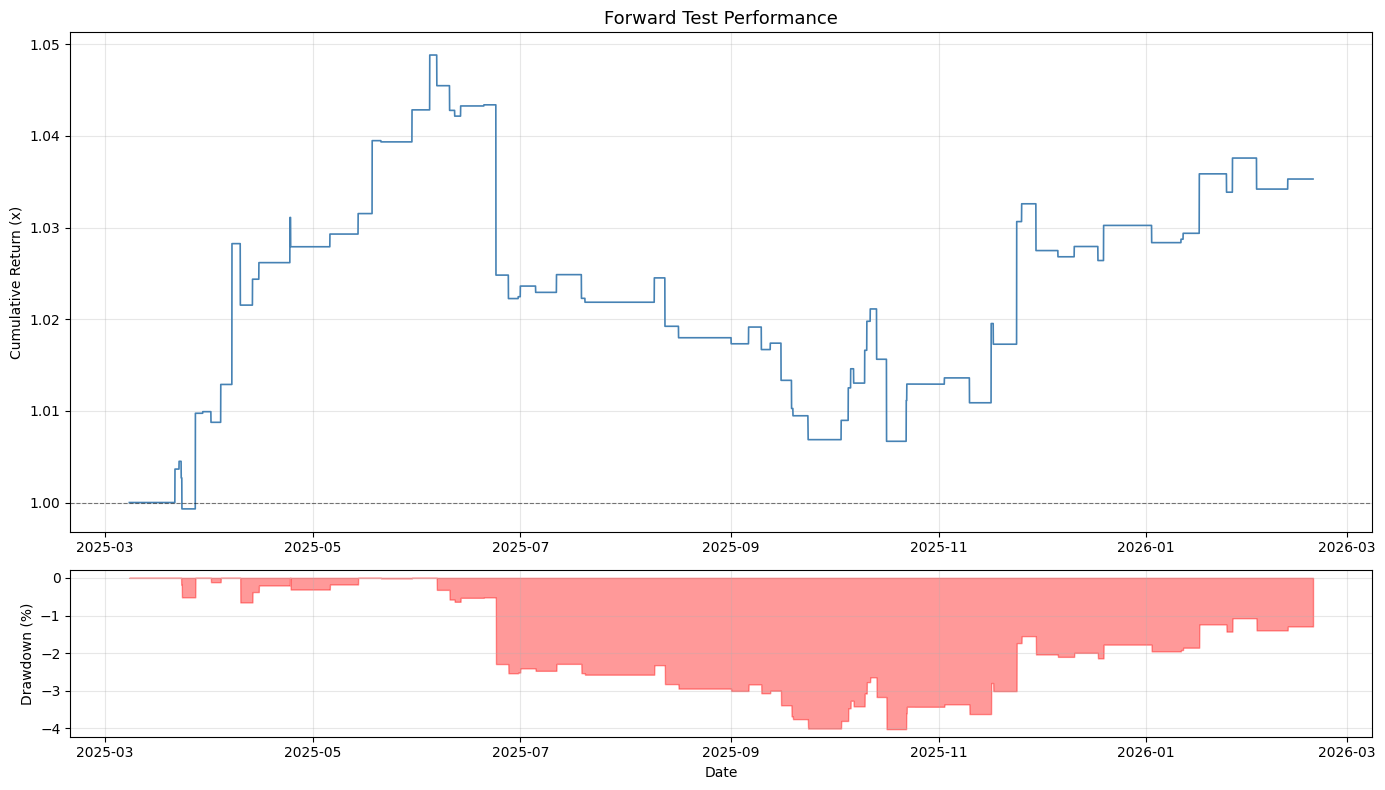

In [92]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


def plot_performance(returns, timestamps=None, title="Strategy Performance"):
    equity = (1 + returns.fillna(0)).cumprod()
    x = timestamps if timestamps is not None else returns.index

    fig, axes = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw={"height_ratios": [3, 1]})

    axes[0].plot(x, equity, color="steelblue", linewidth=1.2)
    axes[0].set_title(title, fontsize=13)
    axes[0].set_ylabel("Cumulative Return (x)")
    axes[0].axhline(1, color="black", linewidth=0.8, linestyle="--", alpha=0.5)
    axes[0].grid(True, alpha=0.3)

    rolling_max = equity.cummax()
    drawdown = (equity / rolling_max - 1) * 100
    axes[1].fill_between(x, drawdown, 0, color="red", alpha=0.4)
    axes[1].set_ylabel("Drawdown (%)")
    axes[1].set_xlabel("Date")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_performance(test_result[0], timestamps=test_df["timestamp"], title="Forward Test Performance")